# NOTEBOOK P7 FFT LEARNABLE
bird_env: no gpu contains audiomentation
birdgpu: cuda ok

### todo 
refaire un deuxiéme run avec le last run_id
faire des tests!!!
pourrait t'on changer certains parmétre de train a non train ou vice versa dans resume_training?
https://anaconda.org/conda-forge/grad-cam

                 forward_basis_init
                         ↓
       ┌────────────────────────────────────┐
       │ self.forward_basis = Parameter(...)│
       └────────────────────────────────────┘
                         ↓
        [used in model forward pass]
                         ↓
                loss.backward()
                         ↓
   self.forward_basis.grad is computed (by autograd)
                         ↓
              optimizer.step()
                         ↓
    self.forward_basis.data is modified (learned!)


In [27]:
import torch
print(torch.cuda.is_available())       
print(torch.version.cuda)               
print(torch.backends.cudnn.version())   
print('Devices avalaible: ',torch.cuda.device_count()) 

True
11.8
90100
Devices avalaible:  1


In [28]:
import os
import time
import pandas as pd
import numpy as np
import librosa
import librosa.display
from IPython.display import Audio
from PIL import Image, ImageOps
from PIL import Image as pil
from p7_utilities import custom_p7_melspectrogram
from p7_utilities import custom_p7_spectrograms_for_audio
from pkg_resources import parse_version
if parse_version(pil.__version__)>=parse_version('10.0.0'):
    Image.ANTIALIAS=Image.LANCZOS
    
import matplotlib.cm as cm

# adapted from NVIDIA
from STFT.stft import STFT # initial code from nvidia
#from STFT.stft import STFTLEARN # adapted code for our needs

dataset_root_folder='/home/christophe/birdclef/'
# contains audio files from birds
audio_input_folder = dataset_root_folder+"train_audio"
# contains file produced in script augmented_data_maker
audio_augemented_folder=dataset_root_folder+"train_audio_aug"
# not used
image_output_folder = dataset_root_folder+"train_images"


# Spectrogram example

ici nous reprenons "pour voir" du code utilsant la librairie librosa et qui génere les spectrogrammes.
Ces spectrogrames sont une représentation des fréquences d'un signal sonore au cours du temps.
On peut les voir comme des images et ce point est exploité par les compétiteurs Kaggle. Ils vont souvent faire du transfer learning avec des CNN type Resnet ou EfficientNet. 

Notre approche est similaire, à la différence que la partie production de spectrogrammes est assurée par un réseau de neurones et que ce réseau est entrainable. 

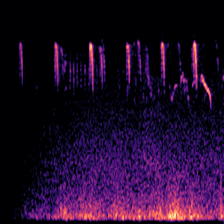

In [29]:
#generates spectrograms are generated on audio clips this long
#audio clips shorter than this are ignored
audio_duration = 5.0

#generates up to this many clips per file (multiples of audio_duration)
#remainders of audio clip length / audio_duration are ignored
max_clips_per_audio_file = 1000

#image size (image_size x image_size)
image_size = 224

#processes up to this many audio files per species
max_audio_input_per_species = 1000

#setting this above 0 will cause processing to start at a folder after the first
#useful for restarting / continuing in case of running out of time / crash (folders are processed alphabetically)
start_at_folder_offset = 0

def spectrograms_for_audio(dirname, filename, preview=False):
    # Calculate total duration of the audio file
    audio_path = os.path.join(dirname, filename)
    audio_data, sr = librosa.load(audio_path, sr=None)
    total_duration = librosa.get_duration(path=audio_path)
    
    # Determine how many full segments of audio_duration fit in the audio file
    num_segments = int(total_duration // audio_duration)
    #print('debug number f segments: ',num_segments)
    if num_segments == 0: return 0
    if num_segments > max_clips_per_audio_file: num_segments = max_clips_per_audio_file
        
    for segment in range(num_segments):

        offset_samples = int(segment * audio_duration * sr)
        end_samples = int(offset_samples + audio_duration * sr)
        
        segment_data = audio_data[offset_samples:end_samples]
        
        S = librosa.feature.melspectrogram(y=segment_data, sr=sr, n_mels=128)
        S_db = librosa.amplitude_to_db(S, ref=np.max)
                
        #convert spectrogram data into directly into image (much faster than matplotlib)
        normalized_array = (S_db - np.min(S_db)) / (np.max(S_db) - np.min(S_db))
        
        #set color mapping 
        spectrogram_image = cm.magma(normalized_array)[:, :, :3]
        spectrogram_image = (spectrogram_image * 255).astype(np.uint8)
        spectrogram_image = Image.fromarray(spectrogram_image)
        
        #resize and flip (so consistent with original dataset)
        spectrogram_image = spectrogram_image.resize((image_size, image_size), Image.ANTIALIAS)
        spectrogram_image = ImageOps.flip(spectrogram_image)
        
        if preview:
            display(Audio(data=segment_data, rate=sr))
            return spectrogram_image
        
        output_folder = os.path.join(image_output_folder, os.path.basename(os.path.normpath(dirname)))
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        # Naming files with an offset to indicate seconds offset
        base_filename = filename.replace('.ogg', '')
        output_filename = os.path.join(output_folder, f"{base_filename}_{int((segment + 1) * audio_duration):02d}.png")
        
        spectrogram_image.save(output_filename)

    return num_segments
spectrograms_for_audio(f"{audio_input_folder}/zitcis1/", "XC655341.ogg", preview=True)


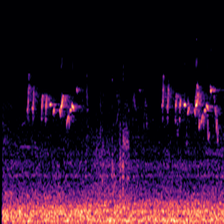

In [30]:
spectrograms_for_audio(f"{audio_input_folder}/bkcbul1/", "XC129030.ogg", preview=True)


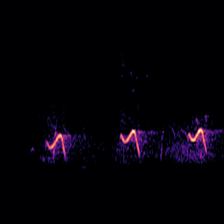

In [31]:
spectrograms_for_audio(f"{audio_input_folder}/asikoe2/", "XC138196.ogg", preview=True)

# P7 first explorations 

Iic nous prenons en main la librairie librosa que nous utiliserons pour notamment charger les fichiers audio (au format .ogg).  

Nous comparons la stft librosa et la classe STFT (issue d'un repo NVIDIA). C'est ainsi l'occasion de vérifier que les deux implémentations renvoient des données semblables. 

Une comparaison des temps de calcul est également réalisé. 


4.3746562e-17


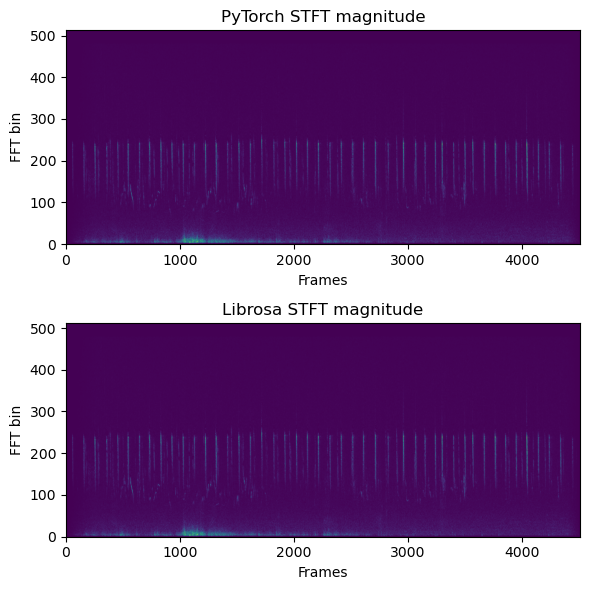

In [32]:
import torch

import librosa 
import matplotlib.pyplot as plt

audio_file_test=f"{audio_input_folder}/zitcis1/XC655341.ogg"
assert os.path.exists(audio_file_test)
load_start_time=time.time()
audio,_ = librosa.load(audio_file_test,sr=None)
load_time=time.time()-load_start_time
audio_for_spectro=audio.copy()

filter_length = 1024
hop_length = 256
win_length = 1024 # doesn't need to be specified. if not specified, it's the same as filter_length
window = 'hann'
start_librosa_stft_time=time.time()
librosa_stft = librosa.stft(audio, n_fft=filter_length, hop_length=hop_length, window=window)
_magnitude = np.abs(librosa_stft)
libbrosa_stft_time=time.time()-start_librosa_stft_time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
audio = torch.FloatTensor(audio)
audio = audio.unsqueeze(0)
audio = audio.to(device)

stft = STFT(
    filter_length=filter_length, 
    hop_length=hop_length, 
    win_length=win_length,
    window=window
).to(device)
nvidia_stft_start_time=time.time()
magnitude, phase = stft.transform(audio)
nvidia_stft_time=time.time()-nvidia_stft_start_time

plt.figure(figsize=(6, 6))
plt.subplot(211)
plt.title('PyTorch STFT magnitude')
plt.xlabel('Frames')
plt.ylabel('FFT bin')
plt.imshow(20*np.log10(1+magnitude[0].cpu().data.numpy()), aspect='auto', origin='lower')

plt.subplot(212)
plt.title('Librosa STFT magnitude')
plt.xlabel('Frames')
plt.ylabel('FFT bin')
plt.imshow(20*np.log10(1+_magnitude), aspect='auto', origin='lower')
plt.tight_layout()
plt.savefig('/home/christophe/birdclef/images_stft/stft.png')

# here we check the transform + inverse gives back the original audio
output = stft.inverse(magnitude, phase)
output = output.cpu().data.numpy()[..., :]
audio = audio.cpu().data.numpy()[..., :]
assert np.allclose(output,audio,atol=1e-7) # returns false if atol<1e-7
print(np.mean((output - audio) ** 2)) # on order of 1e-17

# nvidia time benchmark on cpu
device = torch.device("cuda" if False else "cpu")

audio = torch.FloatTensor(audio)
audio = audio.unsqueeze(0)
audio = audio.to(device)

stft = STFT(
    filter_length=filter_length, 
    hop_length=hop_length, 
    win_length=win_length,
    window=window
).to(device)

nvidia_stft_start_time=time.time()
magnitude, phase = stft.transform(audio)
nvidia_stft_time_cpu=time.time()-nvidia_stft_start_time

del device,stft


Les deux spectrogrammes sont indiscernables à l'oeil nu. Ci dessous un graphique de la différence des deux spectrogrammes ci dessus. 

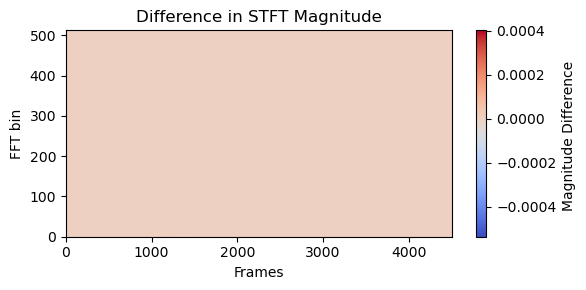

In [33]:
import numpy as np
import matplotlib.pyplot as plt
difference=_magnitude-magnitude[0].cpu().data.numpy()
plt.figure(figsize=(6, 3))
plt.title('Difference in STFT Magnitude')
plt.xlabel('Frames')
plt.ylabel('FFT bin')
plt.imshow(difference, aspect='auto', origin='lower', cmap='coolwarm')
plt.colorbar(label='Magnitude Difference ')
plt.tight_layout()
#plt.savefig('/home/christophe/birdclef/images_stft/difference.png')
plt.show()

Les variations sont très faibles: +/- 0.0004

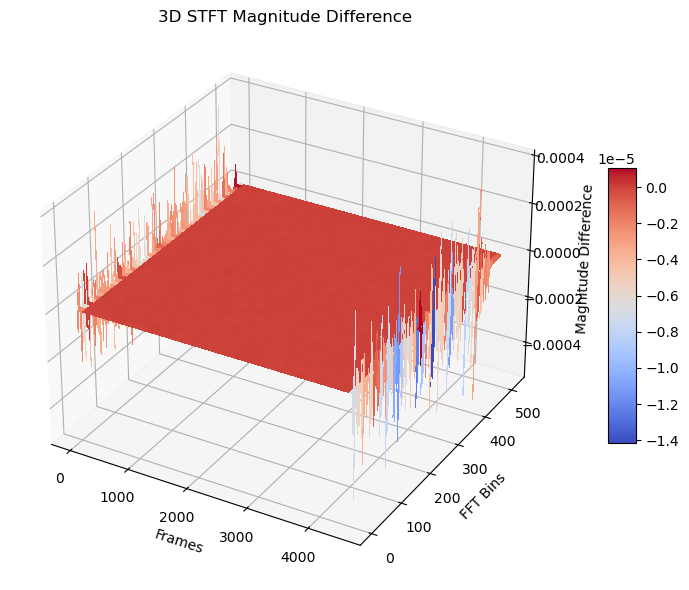

In [34]:
import numpy as np
import matplotlib.pyplot as plt


assert _magnitude.shape==magnitude[0].cpu().data.numpy().shape

difference = _magnitude - magnitude[0].cpu().data.numpy()

# Get the shape
num_bins, num_frames = difference.shape

# Create coordinate grids for X (frames) and Y (FFT bins)
X, Y = np.meshgrid(np.arange(num_frames), np.arange(num_bins))

# Create the plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(X, Y, difference, cmap='coolwarm', linewidth=0, antialiased=False)

# Labels and colorbar
ax.set_title('3D STFT Magnitude Difference')
ax.set_xlabel('Frames')
ax.set_ylabel('FFT Bins')
ax.set_zlabel('Magnitude Difference')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.tight_layout()
plt.show()


On observe quelques différences de valeurs au bord des maps,la forme (shape) est la même.

Ci dessous les statistiques des temps de calcul des deux implémentations de la stft:

| Métrique                         | Durée (secondes) | Facteur d'accélération (par rapport à Librosa STFT) |
| :------------------------------- | :--------------- | :-------------------------------------------------- |
| **Temps de chargement audio** | 0.0269215 | N/A                                                 |
| **Librosa STFT (CPU)** | 0.0162759  | 1x                                                  |
| **NVIDIA Inspired STFT (GPU)** | {{nvidia_stft_time:.7f}} | {{(libbrosa_stft_time/nvidia_stft_time):.2f}}x      |
| **NVIDIA Inspired STFT (CPU)** | {{nvidia_stft_time_cpu:.7f}} | {{(libbrosa_stft_time/nvidia_stft_time_cpu):.2f}}x |

---

**Observations :**

* Le chargement des données audio a pris **{{load_time:.7f}} secondes**.
* L'implémentation STFT inspirée de NVIDIA est **{{(libbrosa_stft_time/nvidia_stft_time):.2f}} fois plus rapide** que l'implémentation Librosa STFT lorsqu'elle s'exécute sur le **GPU**.
* Même sur le **CPU**, l'implémentation STFT inspirée de NVIDIA est **{{(libbrosa_stft_time/nvidia_stft_time_cpu):.2f}} fois plus rapide** que l'implémentation Librosa STFT.

In [35]:
print(f'Time to load audio data: {load_time:.7f} seconds')
print(f'Librosa stft implementation: {libbrosa_stft_time:.7f} seconds (CPU)')
print(f'Nvidia inspired stft implementation: {nvidia_stft_time:.7f} seconds (GPU)')
print('Audio data on GPU: ')
print(f'Nvidia implementation is: {(libbrosa_stft_time/nvidia_stft_time)} times faster')
print('Audio data on cpu: ')
print(f'Nvidia inspired stft implementation: {nvidia_stft_time_cpu:.7f} seconds (CPU)')
print(f'Nvidia implementation is: {(libbrosa_stft_time/nvidia_stft_time_cpu)} times faster')
data = {
    "Description": [
        "Time to load audio data",
        "Librosa stft implementation",
        "Nvidia inspired stft implementation (GPU)",
        "Nvidia implementation speedup (GPU)",
        "Nvidia inspired stft implementation (CPU)",
        "Nvidia implementation speedup (CPU)"
    ],
    "Value": [
        f"{load_time:.7f} seconds",
        f"{libbrosa_stft_time:.7f} seconds",
        f"{nvidia_stft_time:.7f} seconds",
        f"{libbrosa_stft_time/nvidia_stft_time} times faster",
        f"{nvidia_stft_time_cpu:.7f} seconds",
        f"{libbrosa_stft_time/nvidia_stft_time_cpu} times faster"
    ]
}

df = pd.DataFrame(data)
df


Time to load audio data: 0.0211539 seconds
Librosa stft implementation: 0.0224557 seconds (CPU)
Nvidia inspired stft implementation: 0.0004079 seconds (GPU)
Audio data on GPU: 
Nvidia implementation is: 55.047340736411456 times faster
Audio data on cpu: 
Nvidia inspired stft implementation: 0.0162020 seconds (CPU)
Nvidia implementation is: 1.3859850491494496 times faster


Description                            Value
0                    Time to load audio data                0.0211539 seconds
1                Librosa stft implementation                0.0224557 seconds
2  Nvidia inspired stft implementation (GPU)                0.0004079 seconds
3        Nvidia implementation speedup (GPU)  55.047340736411456 times faster
4  Nvidia inspired stft implementation (CPU)                0.0162020 seconds
5        Nvidia implementation speedup (CPU)  1.3859850491494496 times faster

- Le portage de l'audio sur GPU assure une nette amélioration du temps de calcul, l'implémentation NVIDIA est beaucoup plus rapide, sur cpu ses performances sont nettement plus faibles. 

On a cependant noté des variations importantes de ces temps de calcul, ceci sur les mêmes données.

In [36]:

df


Description                            Value
0                    Time to load audio data                0.0211539 seconds
1                Librosa stft implementation                0.0224557 seconds
2  Nvidia inspired stft implementation (GPU)                0.0004079 seconds
3        Nvidia implementation speedup (GPU)  55.047340736411456 times faster
4  Nvidia inspired stft implementation (CPU)                0.0162020 seconds
5        Nvidia implementation speedup (CPU)  1.3859850491494496 times faster

# NVIDIA TACHOTRON

Ici nous récupérons une classe: TACOTRON fournie par NVIDIA héritant de nn.Module.
Initialement cette classe n'était pas entrainable, nous l'avons donc modifiée.
Dans notre version, mel_basis est modifiable durant l'entraînement et nous avons rajouté une méthode forward qui renvoie le spectrogramme.

Le module STFT que nous avons déjà analysé plus haut a été customisé en un module STFTLEARN qui lui est entraînable.

On vérifie ci dessous que nos customisations n'ont pas altéré la production des spectrogrames

In [ ]:
from scipy.signal import get_window
from librosa.util import pad_center, tiny
import torch.nn.functional as F


# our class that is learnable
class STFTLEARN(torch.nn.Module):
    def __init__(self, filter_length=1024, hop_length=512, win_length=None,
                 window='hann', learn_window=False,learn_fft=False):
        """
        This module implements an STFT using 1D convolution and 1D transpose convolutions.
        This is a bit tricky so there are some cases that probably won't work as working
        out the same sizes before and after in all overlap add setups is tough. Right now,
        this code should work with hop lengths that are half the filter length (50% overlap
        between frames).

        Keyword Arguments:
            filter_length {int} -- Length of filters used (default: {1024})
            hop_length {int} -- Hop length of STFT (restrict to 50% overlap between frames) (default: {512})
            win_length {[type]} -- Length of the window function applied to each frame (if not specified, it
                equals the filter length). (default: {None})
            window {str} -- Type of window to use (options are bartlett, hann, hamming, blackman, blackmanharris)
                (default: {'hann'})
            learn_basis {bool} -- If True, the Fourier basis will be learned. (default: {False})
            learn_window {bool} -- If True, the window function will be learned. (default: {False})
        """
        super(STFTLEARN, self).__init__()
        self.filter_length = filter_length
        self.hop_length = hop_length
        self.win_length = win_length if win_length else filter_length
        self.window_type = window 
        
        self.pad_amount = int(self.filter_length / 2)
        scale = self.filter_length / self.hop_length
        self.learn_window=learn_window
        self.learn_fft=learn_fft
       
        fourier_basis = np.fft.fft(np.eye(self.filter_length))
        cutoff = int((self.filter_length / 2 + 1))
        fourier_basis = np.vstack([np.real(fourier_basis[:cutoff, :]),
                                   np.imag(fourier_basis[:cutoff, :])])

        # Convert to Torch Tensor
        self.forward_basis_init = torch.FloatTensor(fourier_basis[:, None, :])
        
        self.inverse_basis_init = torch.FloatTensor(
            np.linalg.pinv(scale * fourier_basis).T[:, None, :])

        # Make basis learnable if specified
        if self.learn_fft:
            
            self.register_buffer('initial_forward_basis', self.forward_basis_init.clone())
            
            self.forward_basis = torch.nn.Parameter(self.forward_basis_init.clone(),requires_grad=True)
            self.inverse_basis = torch.nn.Parameter(self.inverse_basis_init.clone(),requires_grad=True)
            
        
        else:
            self.register_buffer('forward_basis', self.forward_basis_init.float())
            self.register_buffer('inverse_basis',self.inverse_basis_init.float())

    
        assert(filter_length >= self.win_length)

        # 2. Initialize Window Function
        fft_window_init = get_window(self.window_type, self.win_length, fftbins=True)
        
        fft_window_init = pad_center(data=fft_window_init, size=filter_length, mode='constant')
        
        self.fft_window_init_tensor = torch.from_numpy(fft_window_init).float()

        if self.learn_window:
            
            self.register_buffer('initial_fft_window', self.fft_window_init_tensor.clone())
            self.fft_window = torch.nn.Parameter(self.fft_window_init_tensor.clone(), requires_grad=True)
        else:
            # If not learning, it remains a buffer
            self.register_buffer('fft_window', self.fft_window_init_tensor.clone())
            self.initial_fft_window = None # Not applicable if not learnable
    

    def enforce_forward_basis_constraints(self, delta=0.001):
        if self.learn_fft and self.initial_forward_basis is not None:
         
            lower_bound = self.initial_forward_basis - delta
            upper_bound = self.initial_forward_basis + delta
            with torch.no_grad():
                self.forward_basis.copy_(torch.clamp(self.forward_basis, min=lower_bound, max=upper_bound))

    def enforce_fft_window_constraints(self, delta=0.001):
        if self.learn_window and self.initial_fft_window is not None:
            lower_bound = self.initial_fft_window - delta
            upper_bound = self.initial_fft_window + delta
            with torch.no_grad():
                self.fft_window.copy_(torch.clamp(self.fft_window, min=lower_bound, max=upper_bound))


    def get_fft_basis(self):
        return self.forward_basis
    

    def get_window_init(self):
        # will be relevant only if learn_window is true
        return self.fft_window
    
    def forward(self, input_data):
        return self.transform(input_data=input_data)


    def transform(self, input_data):
        """Take input data (audio) to STFT domain.

        Arguments:
            input_data {tensor} -- Tensor of floats, with shape (num_batch, num_samples)

        Returns:
            magnitude {tensor} -- Magnitude of STFT with shape (num_batch,
                num_frequencies, num_frames)
            phase {tensor} -- Phase of STFT with shape (num_batch,
                num_frequencies, num_frames)
        """
        num_batches = input_data.shape[0]
        num_samples = input_data.shape[-1]

        self.num_samples = num_samples

        # similar to librosa, reflect-pad the input
        input_data = input_data.view(num_batches, 1, num_samples)

        input_data = F.pad(
            input_data.unsqueeze(1),
            (self.pad_amount, self.pad_amount, 0, 0),
            mode='reflect')
        input_data = input_data.squeeze(1)

        # We need to reshape self.fft_window to [1, 1, filter_length] for broadcasting
        windowed_forward_basis = self.forward_basis * self.fft_window.view(1, 1, -1)


        forward_transform = F.conv1d(
            input_data,
            windowed_forward_basis, # Use the windowed basis here
            stride=self.hop_length,
            padding=0)

        cutoff = int((self.filter_length / 2) + 1)
        real_part = forward_transform[:, :cutoff, :]
        imag_part = forward_transform[:, cutoff:, :]

        magnitude = torch.sqrt(real_part**2 + imag_part**2)
        # Detach phase from the computation graph if you don't need to backpropagate through it.
        # However, for full differentiability, it's often kept. For simplicity, we'll keep it for now.
        phase = torch.atan2(imag_part, real_part)

        return magnitude, phase


In [ ]:
from librosa.filters import mel as librosa_mel_fn
import random
import torch
import torch.nn as nn

def dynamic_range_compression(x, C=1, clip_val=1e-5):
    """
    PARAMS
    ------
    C: compression factor
    """
    return torch.log(torch.clamp(x, min=clip_val) * C)


def dynamic_range_decompression(x, C=1):
    """
    PARAMS
    ------
    C: compression factor used to compress
    """
    return torch.exp(x) / C

class TacotronSTFT(torch.nn.Module):
    def __init__(self, filter_length=1024, hop_length=256, win_length=1024,
                 n_mel_channels=80, sampling_rate=22050, mel_fmin=0.0,
                 mel_fmax=8000.0,mel_trainable=True,fft_learnable=True,learn_win=True):
        super(TacotronSTFT, self).__init__()
        self.n_mel_channels = n_mel_channels
        self.sampling_rate = sampling_rate
        self.stft_fn = STFTLEARN(filter_length, hop_length, win_length,learn_fft=fft_learnable,learn_window=learn_win)
        self.mel_trainable=mel_trainable
        self.fft_trainable=fft_learnable
        
        mel_basis_np = librosa_mel_fn(
            sr=sampling_rate, n_fft=filter_length, n_mels=n_mel_channels, fmin=mel_fmin, fmax=mel_fmax)

        ### mel_basis is now learnable
        if self.mel_trainable:
           
            self.register_buffer('initial_mel_basis', torch.from_numpy(mel_basis_np).float())
            self.mel_basis = nn.Parameter(self.initial_mel_basis.clone(), requires_grad=True)
        
        
        else:
            mel_basis = torch.from_numpy(mel_basis_np).float()
            self.register_buffer('mel_basis', mel_basis)
            self.initial_mel_basis = None # Not applicable if not trainable
       
        

    def spectral_normalize(self, magnitudes):
        output = dynamic_range_compression(magnitudes)
        return output

    def spectral_de_normalize(self, magnitudes):
        output = dynamic_range_decompression(magnitudes)
        return output

    def mel_spectrogram(self, y):
        """Computes mel-spectrograms from a batch of waves
        PARAMS
        ------
        y: Variable(torch.FloatTensor) with shape (B, T) in range [-1, 1]

        RETURNS
        -------
        mel_output: torch.FloatTensor of shape (B, n_mel_channels, T)
        """

        ##### COMMENTED BECAUSE OUR DATA HAS SUCH VALUES ########
        # assert(torch.min(y.data) >= -1)
        # assert(torch.max(y.data) <= 1)

        # V1 stft is calculated with transform
        #magnitudes, phases = self.stft_fn.transform(y)
        # V2 stft is calculated via forward
        magnitudes, phases = self.stft_fn(y)

        #magnitudes = magnitudes.data # was breaking the graph
        magnitudes = magnitudes.clone()
        
        mel_output = torch.matmul(self.mel_basis, magnitudes)
        mel_output = self.spectral_normalize(mel_output)
        return mel_output
    
    # getters
    def get_mel_basis(self):
        return self.mel_basis
    
    def get_stft(self):
        return self.stft_fn.get_fft_basis()
    
    def get_window(self):
        return self.stft_fn.get_window_init()
    
    # it's important to ensure variations of mel filter to be constrained during learning
    def enforce_mel_basis_constraints(self, delta=0.01):
        if self.mel_trainable and self.initial_mel_basis is not None:
            lower_bound = self.initial_mel_basis - delta
            upper_bound = self.initial_mel_basis + delta
            with torch.no_grad():
                self.mel_basis.copy_(torch.clamp(self.mel_basis, min=lower_bound, max=upper_bound))
    
    # learnable spectrogramm
    def forward(self,y):
        return self.mel_spectrogram(y)


##### TESTS ######
tacotron_stft=TacotronSTFT(learn_win=True,fft_learnable=True,mel_trainable=True)
audio_file_test=f"{audio_input_folder}/zitcis1/XC655341.ogg"
#audio_file_test=f"{audio_input_folder}/zitcis1/XC124995.ogg"
#audio_file_test=f"{audio_input_folder}/zitcis1/XC127906.ogg"
assert os.path.exists(audio_file_test)

FS=32000
FIXED_LENGTH = int(5.0 * FS)  # 5 seconds

def get_audio_data(audio_raw_file):
    audio_data, _ = librosa.load(audio_raw_file, sr=FS)
    if len(audio_data) < FIXED_LENGTH:
        
        # Pad with zeros
        pad_width = FIXED_LENGTH - len(audio_data)
        audio_data = np.pad(audio_data, (0, pad_width), mode='constant')
    else:
        
        # Truncate
        audio_data = audio_data[:FIXED_LENGTH]

    return torch.from_numpy(audio_data).unsqueeze(0)

# test of data augmentation, we don't use it anymore, too slow to produce data
# it compiles but for data augmentation we choose to save new .ogg files on disk.
def get_audio_data_augmented(audio_raw_file, apply_augmentation=True,rate_augmentation=0.5):
    audio_data, _ = librosa.load(audio_raw_file, sr=FS)
    audio_data = audio_data.astype(np.float32)


    if apply_augmentation and len(audio_data) > 0:
        # Noise Injection
        if random.random() > rate_augmentation:  
            noise = np.random.randn(len(audio_data))
            audio_data = audio_data + 0.005 * noise
            audio_data = audio_data.astype(np.float32)
            

        # Time Stretching
        if random.random() > rate_augmentation:  
            rate = random.uniform(0.8, 1.2) 
            audio_data = librosa.effects.time_stretch(audio_data, rate=rate)
            audio_data = audio_data.astype(np.float32)
            

        # Pitch Shifting
        if random.random() > rate_augmentation: 
            n_steps = random.uniform(-2, 2)  # Shift pitch by up to 2 steps
            audio_data = librosa.effects.pitch_shift(audio_data, sr=FS, n_steps=n_steps)
            audio_data = audio_data.astype(np.float32)

        # Time Shifting
        if random.random() > 2: # we don't use time shifting  
            shift_max = int(0.1 * len(audio_data)) 
            shift = random.randint(-shift_max, shift_max)
            audio_data = np.roll(audio_data, shift)
            audio_data = audio_data.astype(np.float32)

    # Pad or truncate to fixed length
    if len(audio_data) < FIXED_LENGTH:
        pad_width = FIXED_LENGTH - len(audio_data)
        audio_data = np.pad(audio_data, (0, pad_width), mode='constant')
    else:
        audio_data = audio_data[:FIXED_LENGTH]

    return torch.from_numpy(audio_data).unsqueeze(0)


# TESTS
audio_torch_spectro=get_audio_data(audio_raw_file=audio_file_test)

audio_torch_spectro_2=get_audio_data_augmented(audio_raw_file=audio_file_test,apply_augmentation=False)


assert np.allclose(audio_torch_spectro.detach().numpy(),audio_torch_spectro_2.detach().numpy())

audio_torch_augmented=get_audio_data_augmented(audio_raw_file=audio_file_test,apply_augmentation=True)

spectro_augmented=tacotron_stft(y=audio_torch_augmented)
spectro_augmented=tacotron_stft.mel_spectrogram(y=audio_torch_augmented)
# initial implementation:
spectro = tacotron_stft.mel_spectrogram(y=audio_torch_spectro)

# In our custom layer this the forward method that produces the spectrogram
output_tacrotron = tacotron_stft(y=audio_torch_spectro.unsqueeze(0))

print('Output of tachrotron layer:')
assert type(output_tacrotron) is torch.Tensor
print(type(output_tacrotron))
assert output_tacrotron.shape==(1,80,626), f'expected shape to be (1,80,626) got: {output_tacrotron.shape}'
print('Signal processing output shape',output_tacrotron.shape)

assert np.allclose(output_tacrotron.detach().numpy(), spectro.detach().numpy()),"classical method and neural network output differ"

Output of tachrotron layer:
<class 'torch.Tensor'>
Signal processing output shape torch.Size([1, 80, 626])


Visualistaion d'un spectre obtenu avec la méthode classique:

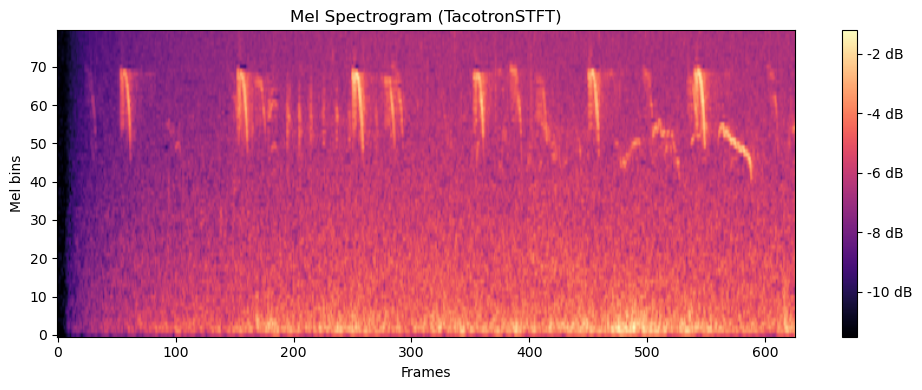

In [39]:
plt.figure(figsize=(10, 4))
plt.imshow(spectro.squeeze().detach().numpy(), aspect='auto', origin='lower', cmap='magma')
plt.title('Mel Spectrogram (TacotronSTFT)')
plt.xlabel('Frames')
plt.ylabel('Mel bins')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

Visualisation du même fichier audio après data augmentation:

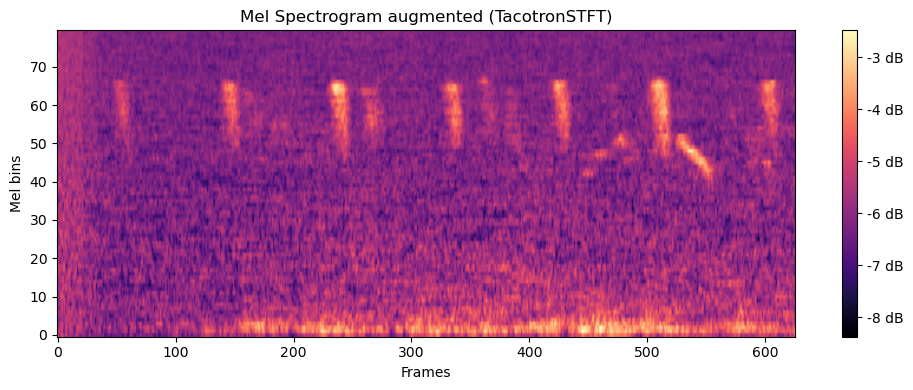

In [40]:
plt.figure(figsize=(10, 4))
plt.imshow(spectro_augmented.squeeze().detach().numpy(), aspect='auto', origin='lower', cmap='magma')
plt.title('Mel Spectrogram augmented (TacotronSTFT)')
plt.xlabel('Frames')
plt.ylabel('Mel bins')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

Visualisation du spectrograme produit par le réseau (tel que nous l'utiliserons pour les entraînements)

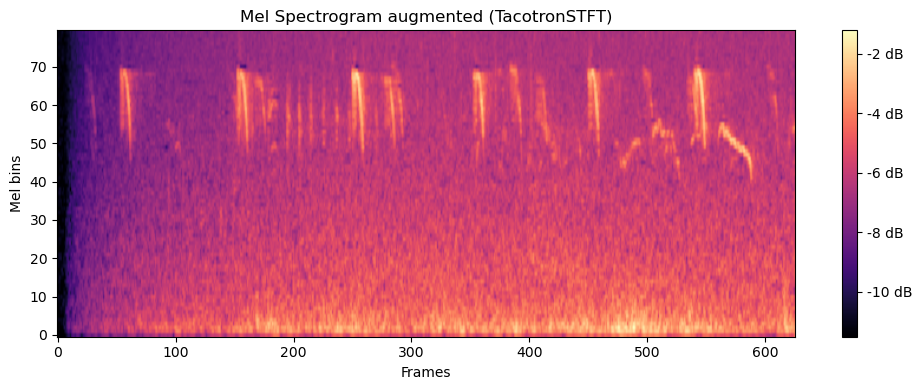

In [41]:
plt.figure(figsize=(10, 4))
plt.imshow(output_tacrotron.detach().numpy().reshape(80, 626), aspect='auto', origin='lower', cmap='magma')
plt.title('Mel Spectrogram augmented (TacotronSTFT)')
plt.xlabel('Frames')
plt.ylabel('Mel bins')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

# EFFICIENTNET

- Ici notre CNN efficientnet qui va prendre les spectrogrames en entrée. Initialement prévu pour prendre des images avec trois couleurs, il a fallu modifier la première couche de convolution pour accepter des 'images' a un seul canal. 

- La tête de classification est composée d'un Dropout, d'une couche layernorm et d'une couche linear qui produit une sortie à 182 dimensions. 

- Nous pourrons dégeler des couches. Il est à noter qu'efficiennet n'a pas été entrainé sur ce type de données, ainsi nous produirons un modéle 'from scratch'.  

In [42]:
# try to unfreeze all!!!!
# kaggle eficient net ?
# BO is smallest 
import torch

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes,pretrained=True,head_trainable=True):
        super().__init__()

        # Load EfficientNet with pretrained weights
        if pretrained:
            self.model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        else:
            self.model=efficientnet_b0()
        # Replace first conv to accept 1-channel input
        old_conv = self.model.features[0][0]
        new_conv = nn.Conv2d(
            in_channels=1,
            out_channels=old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=old_conv.bias is not None,
        )
        with torch.no_grad():
            new_conv.weight[:] = old_conv.weight.mean(dim=1, keepdim=True)
        self.model.features[0][0] = new_conv

       
        in_features = self.model.classifier[1].in_features

        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.2),  
            #nn.BatchNorm1d(in_features),
            nn.LayerNorm(in_features),
            nn.Linear(in_features, num_classes)
        )
        #self.model.classifier[1] = nn.Linear(in_features, num_classes)
    def forward(self, x):
        # Ensure input has 4 dimensions (batch_size, channels, height, width)
        if x.dim() == 2:
            x = x.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
        elif x.dim() == 3:
            x = x.unsqueeze(1) # Add channel dimension (assuming batch is already there)

        return self.model(x)   

# test 
model = CustomEfficientNet(num_classes=182)
model.eval()
output = model(spectro)  
output3=model(output_tacrotron)
print('classifier output: ',output.shape)
print(50*"#")
print(model)
print(50*"#")
del model


classifier output:  torch.Size([1, 182])
##################################################
CustomEfficientNet(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_

# BirdNetFFT

- Ici nous accolons notre classe Tachrotron et le réseau EfficientNet pour ainsi construire un réseau capable de prendre en entrée les fichiers audio et faire de la classification. 

In [ ]:
import torch
import torch.nn as nn

def inspect_model_layers(model,print_all=False):
    '''
    - allows to check wheter any layer of a model is trainable or not
    - gives infos on number of params
    '''
    if print_all:
        for name, param in model.named_parameters():
            print(f"{name:60} | requires_grad = {param.requires_grad}")
        
    else:
        print("\nTrainable layers:")
        for name, param in model.named_parameters():
            if param.requires_grad:
                print(f"  {name}")
                print('---------')

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params
    if print_all:
        print('')
        print(f"Total parameters:     {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        print(f"Frozen parameters:    {frozen_params:,}")



class BirdNetFFT(nn.Module):
    def __init__(self, num_classes,pretrained,mel_trainable=True,efficient_trainable=True,num_features=[7,8],
                 fft_t=True,win_l=True,classifer_train=True):
        super().__init__()

        self.spectro_layer=TacotronSTFT(mel_trainable=mel_trainable,fft_learnable=fft_t,learn_win=win_l)

        self.model = CustomEfficientNet(num_classes=num_classes,pretrained=pretrained)

        '''
        Efficient net can be loaded in various configurations:
        
        '''
        # == transfer learning: pretrained + upper layers trainable
        if efficient_trainable and pretrained:
            for param in self.model.model.parameters():
                param.requires_grad = False

            assert type(num_features) is list, "features must be a list!!"
            for feature in num_features:
                
                for param in self.model.model.features[feature].parameters():
                    param.requires_grad = True

        # === No pretrained weights loaded: we train all layers ====
        elif efficient_trainable and not pretrained:
            for param in self.model.model.parameters():
                param.requires_grad = True

        # ===== INFERENCE MODE ======
        elif not efficient_trainable:
            
            for param in self.model.model.parameters():
                param.requires_grad = False
        else:
            raise ValueError('Efficient net configuration not relevant')

        # ===  classifier head ===
        if classifer_train:
            for param in self.model.model.classifier.parameters():
                param.requires_grad = True
        else:
            for param in self.model.model.classifier.parameters():
                param.requires_grad = False

        # if fft_t:
        #     self.spectro_layer.stft_fn.forward_basis.requires_grad =True
        
            

    # === Getters that allow to inspect some signal processing layers
    def get_tachrotron_mel_basis(self):
        return self.spectro_layer.get_mel_basis()

    def get_tachrotron_stft(self):
        return self.spectro_layer.get_stft()
    
    def get_tachrotron_window(self):
        return self.spectro_layer.get_window()
    

    def forward(self, x):
        
        x=self.spectro_layer(x)
        
        return self.model(x)
    
audio_file_test=f"{audio_input_folder}/zitcis1/XC655341.ogg"
audio_file_test=f"{audio_input_folder}/zitcis1/XC124995.ogg"
audio_file_test=f"{audio_input_folder}/zitcis1/XC127906.ogg"

assert os.path.exists(audio_file_test)

audio_torch_spectro=get_audio_data(audio_raw_file=audio_file_test)

audio_torch_augmented=get_audio_data_augmented(audio_raw_file=audio_file_test,apply_augmentation=True)


audio_torch_augmented = audio_torch_augmented

bird_model = BirdNetFFT(num_classes=182,pretrained=False,efficient_trainable=True,mel_trainable=True,
                        win_l=True,fft_t=True)

bird_model.eval()

output_bird=bird_model(audio_torch_spectro)

output_bird_aug=bird_model(audio_torch_augmented)

print(torch.argmax(output_bird).detach().numpy())

inspect_model_layers(bird_model,print_all=False)

mel_basis_model=bird_model.get_tachrotron_mel_basis()

stft_fn_basis=bird_model.get_tachrotron_stft()

window_bird_model=bird_model.get_tachrotron_window()

del bird_model


52

Trainable layers:
  spectro_layer.mel_basis
---------
  spectro_layer.stft_fn.forward_basis
---------
  spectro_layer.stft_fn.inverse_basis
---------
  spectro_layer.stft_fn.fft_window
---------
  model.model.features.0.0.weight
---------
  model.model.features.0.1.weight
---------
  model.model.features.0.1.bias
---------
  model.model.features.1.0.block.0.0.weight
---------
  model.model.features.1.0.block.0.1.weight
---------
  model.model.features.1.0.block.0.1.bias
---------
  model.model.features.1.0.block.1.fc1.weight
---------
  model.model.features.1.0.block.1.fc1.bias
---------
  model.model.features.1.0.block.1.fc2.weight
---------
  model.model.features.1.0.block.1.fc2.bias
---------
  model.model.features.1.0.block.2.0.weight
---------
  model.model.features.1.0.block.2.1.weight
---------
  model.model.features.1.0.block.2.1.bias
---------
  model.model.features.2.0.block.0.0.weight
---------
  model.model.features.2.0.block.0.1.weight
---------
  model.model.features.

# mel basis

Ces 'bases mel' sont utilsées pour la production des spectrogrames, on peut les voir comme des filtres 2D. 


Mel basis: 
Class:  <class 'torch.nn.parameter.Parameter'>
Shape:  torch.Size([80, 513])
Statistics of mel_basis_np:
Minimum value: 0.0
Maximum value: 0.026492536067962646
Standard deviation: 0.0009837093530222774
Mean value: 9.048947686096653e-05


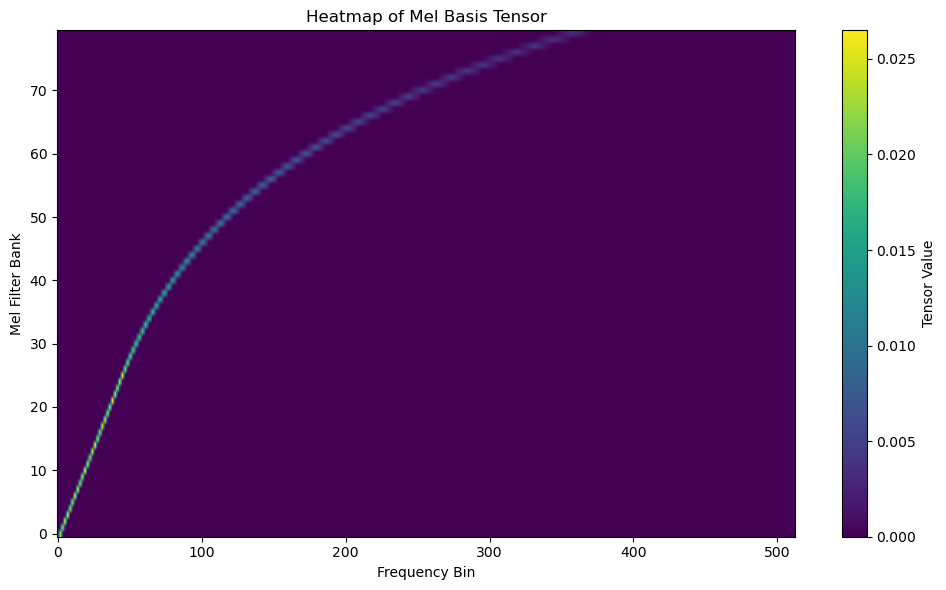

In [44]:
print('Mel basis: ')
print('Class: ',mel_basis_model.__class__)
print('Shape: ',mel_basis_model.shape)
def plot_mel_basis(mel_basis_model,save_plot=False,file_path=None):
    mel_basis_np = mel_basis_model.cpu().detach().numpy()
    print("Statistics of mel_basis_np:")
    print(f"Minimum value: {np.min(mel_basis_np)}")
    print(f"Maximum value: {np.max(mel_basis_np)}")
    print(f"Standard deviation: {np.std(mel_basis_np)}")
    print(f"Mean value: {np.mean(mel_basis_np)}")
    plt.figure(figsize=(10, 6)) # Adjust figure size as needed for better visualization
    plt.imshow(mel_basis_np, aspect='auto', origin='lower', cmap='viridis') # 'viridis' is a good default colormap
    plt.colorbar(label='Tensor Value')
    plt.title('Heatmap of Mel Basis Tensor')
    plt.xlabel('Frequency Bin')
    plt.ylabel('Mel Filter Bank')
    plt.tight_layout()
    if not save_plot:
        plt.show()
    else:
        plt.savefig(file_path)
        return file_path
path=plot_mel_basis(mel_basis_model,save_plot=False)
assert path is None


la forme du filtre est en acccord avec la documentation de librosa: 

##### https://librosa.org/doc/0.11.0/generated/librosa.filters.mel.html#librosa.filters.mel

# visualisation de la matrice de la fft 

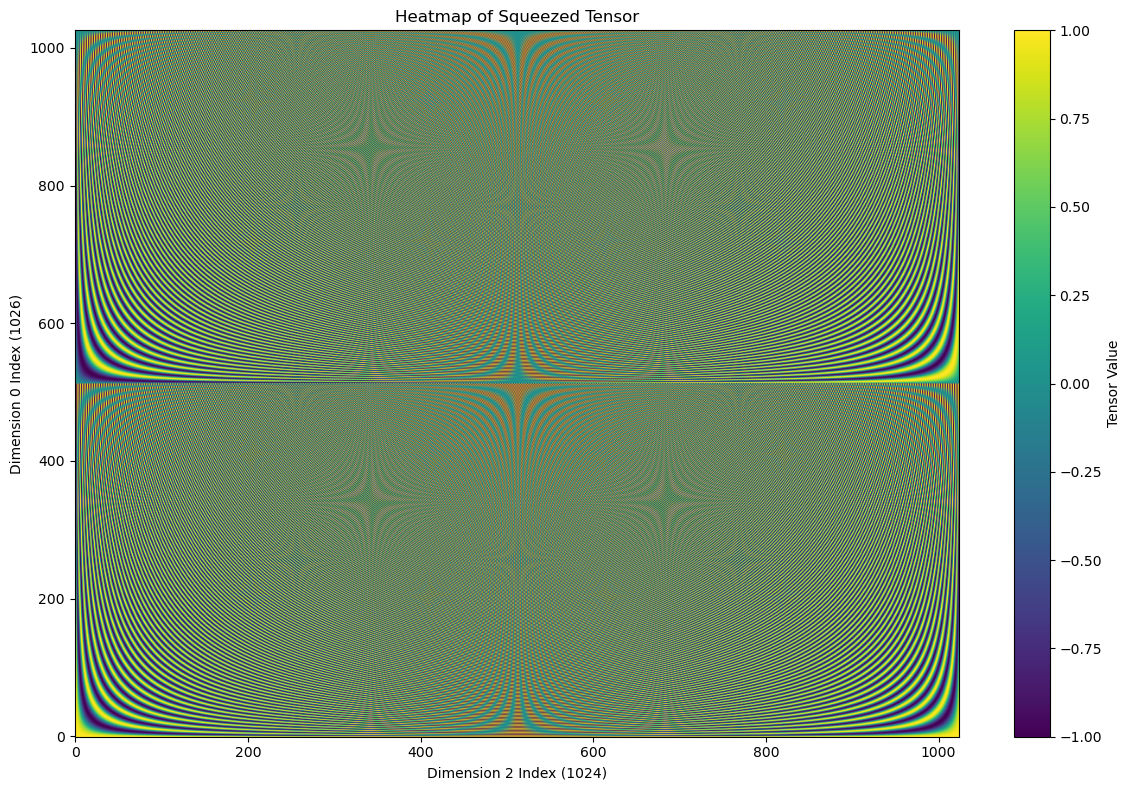

In [45]:
def plot_fft_basis(stft_fn,save_plot=False,file_path=None):

    squeezed_fft_basis = stft_fn.squeeze(1).cpu()

    #print(f"Squeezed tensor shape: {squeezed_fft_basis.shape}")
    squeezed_tensor_np = squeezed_fft_basis.detach().numpy()

    plt.figure(figsize=(12, 8)) # Adjust figure size as needed
    plt.imshow(squeezed_tensor_np, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Tensor Value')
    plt.title('Heatmap of Squeezed Tensor')
    plt.xlabel('Dimension 2 Index (1024)')
    plt.ylabel('Dimension 0 Index (1026)')
    plt.tight_layout()
    if not save_plot:
        plt.show()
    else:
        plt.savefig(file_path)
        return file_path
fft_path=plot_fft_basis(stft_fn_basis,save_plot=False)
assert fft_path is None

On retrouve ces structures typiques des matrices des transformations de fourier que nous observions dans le projet radar. 

Ci dessous la fenêtre de Hann utilsée également: 

torch.Size([1024])


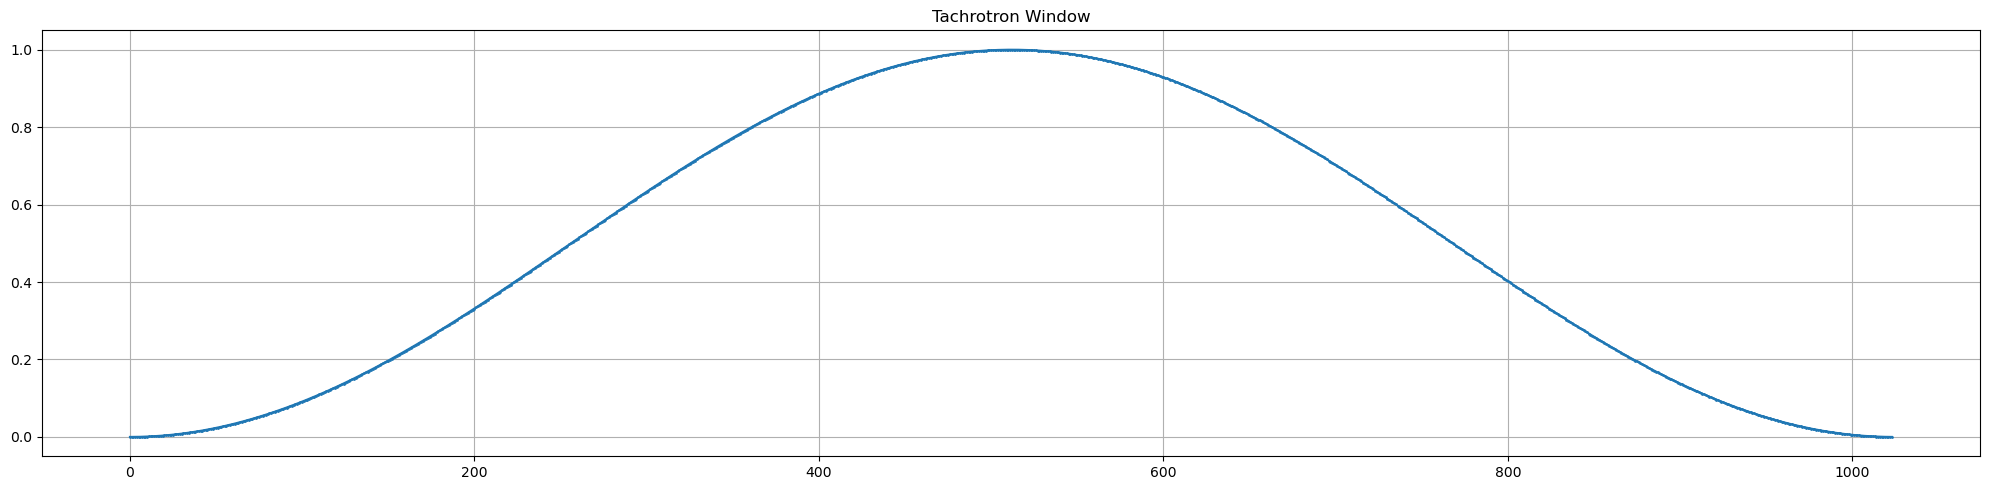

In [46]:
print(window_bird_model.shape)
def plot_window_model(window_bird_model,save_plot=False,file_path=None):
    window_bird_model_np=window_bird_model.cpu().detach().numpy()
    plt.figure(figsize=(20, 5))
    plt.plot(window_bird_model_np, marker='o',markersize=1)  # Line plot with markers
    plt.title("Tachrotron Window")
    plt.xlabel("")
    plt.ylabel("")
    plt.grid(True)
    plt.tight_layout()
    if not save_plot:
        plt.show()
    else:
        
        plt.savefig(file_path)
        return file_path
_=plot_window_model(window_bird_model,save_plot=False)

On a bien des formes typique de fenêtrage, il sera intéréssant de reproduire ces graphiques, aprés entraînement des modèles.

# tests des couches entrainables

Ici nous vérifions que la couche mel_basis peut être ou non rendue entraînable.

Nous faisons de même pour la FFT et le fenêtrage. 

Il est important de vérifier ce point car nos couches sont relativement complexes. 

In [47]:

model_b = BirdNetFFT(num_classes=182,mel_trainable=True,pretrained=True,fft_t=True,win_l=True)
model_b.eval()
audio_file_test=f"{audio_input_folder}/zitcis1/XC655341.ogg"
assert os.path.exists(audio_file_test)

audio_torch_spectro=get_audio_data(audio_raw_file=audio_file_test)
print(audio_torch_spectro.shape)

y = model_b(audio_torch_spectro)  # forward

loss = y.sum()
loss.backward()

# Check if mel_basis is a Parameter (trainable)
mel_basis = model_b.spectro_layer.mel_basis
if isinstance(mel_basis, torch.nn.Parameter):
	assert mel_basis.grad is not None, 'layer mel_basis shall be trainable'
	assert mel_basis.requires_grad
else:
	raise AssertionError('mel_basis is not a Parameter when it should be trainable')


assert model_b.spectro_layer.stft_fn.forward_basis.grad is not None, f'grad: {model_b.spectro_layer.stft_fn.forward_basis.grad}'
assert model_b.spectro_layer.stft_fn.forward_basis.requires_grad
assert model_b.spectro_layer.stft_fn.fft_window.grad is not None, f'grad: {model_b.spectro_layer.stft_fn.fft_window.grad}'
assert model_b.spectro_layer.stft_fn.fft_window.requires_grad
del model_b

model_b = BirdNetFFT(num_classes=182,mel_trainable=False,pretrained=True,fft_t=False,win_l=False)
model_b.eval()

y = model_b(audio_torch_spectro)  # forward

loss = y.sum()
loss.backward()

mel_basis = model_b.spectro_layer.mel_basis
if isinstance(mel_basis, torch.nn.Parameter):
	assert mel_basis.grad is None, 'layer mel_basis shall not be trainable'
else:
	# If it's a buffer, it is not trainable and has no grad attribute
	print('mel_basis is a buffer and not trainable, as expected.')
assert model_b.spectro_layer.stft_fn.forward_basis.grad is None, f'grad: {model_b.spectro_layer.stft_fn.forward_basis.grad}'
assert model_b.spectro_layer.stft_fn.fft_window.grad is None, f'grad: {model_b.spectro_layer.stft_fn.fft_window.grad}'
assert not model_b.spectro_layer.stft_fn.forward_basis.requires_grad
assert not model_b.spectro_layer.stft_fn.fft_window.requires_grad

del model_b


torch.Size([1, 160000])
mel_basis is a buffer and not trainable, as expected.


# dataset building

Les labels représentant les noms des especes peuvent être encodées en entiers, nous utilserons cette représentation dans le dataset. 

asikoe2 index:  4
barswa index:  9


In [49]:
id2label

{0: 'asbfly',
 1: 'ashdro1',
 2: 'ashpri1',
 3: 'ashwoo2',
 4: 'asikoe2',
 5: 'asiope1',
 6: 'aspfly1',
 7: 'aspswi1',
 8: 'barfly1',
 9: 'barswa',
 10: 'bcnher',
 11: 'bkcbul1',
 12: 'bkrfla1',
 13: 'bkskit1',
 14: 'bkwsti',
 15: 'bladro1',
 16: 'blaeag1',
 17: 'blakit1',
 18: 'blhori1',
 19: 'blnmon1',
 20: 'blrwar1',
 21: 'bncwoo3',
 22: 'brakit1',
 23: 'brasta1',
 24: 'brcful1',
 25: 'brfowl1',
 26: 'brnhao1',
 27: 'brnshr',
 28: 'brodro1',
 29: 'brwjac1',
 30: 'brwowl1',
 31: 'btbeat1',
 32: 'bwfshr1',
 33: 'categr',
 34: 'chbeat1',
 35: 'cohcuc1',
 36: 'comfla1',
 37: 'comgre',
 38: 'comior1',
 39: 'comkin1',
 40: 'commoo3',
 41: 'commyn',
 42: 'compea',
 43: 'comros',
 44: 'comsan',
 45: 'comtai1',
 46: 'copbar1',
 47: 'crbsun2',
 48: 'cregos1',
 49: 'crfbar1',
 50: 'crseag1',
 51: 'dafbab1',
 52: 'darter2',
 53: 'eaywag1',
 54: 'emedov2',
 55: 'eucdov',
 56: 'eurbla2',
 57: 'eurcoo',
 58: 'forwag1',
 59: 'gargan',
 60: 'gloibi',
 61: 'goflea1',
 62: 'graher1',
 63: 'grbeat1',
 

# DUMMY classifier baseline

Le dummy classifier avec répartition uniforme des 182 classes renvoie une accuracy de 0.5 à 0.6 %. 

In [50]:
from sklearn.metrics import accuracy_score
num_classes = 182
num_samples = 25000 # same as birdclef dataset size
y_true = np.random.randint(0, num_classes, size=num_samples)

# Random predictions (uniform across all classes)
y_pred = np.random.randint(0, num_classes, size=num_samples)


accuracy_dummy = accuracy_score(y_true, y_pred)

print(f"Dummy classifier accuracy percenatge on {num_samples} samples: {accuracy_dummy*100:.4f} %")
del num_samples,y_pred,y_true


Dummy classifier accuracy percenatge on 25000 samples: 0.5680 %


Ici une première version du dataset ou la data augmentation est appliquée durant l'entrainement (à la volée). Le code compile mais s'est révélé lent. Nous avons donc préféré sauvegarder les fichiers des fichiers audios augmentés.

In [51]:
import os
import torch
from torch.utils.data import Dataset,DataLoader
from torch.utils.data import ConcatDataset
from torch.utils.data import random_split

# V1 dataset where data augmentation is done while training
# gave lenghty training so we prefered to store on the disk the augmented audio files

class BirdAudioDataset(Dataset):
    def __init__(self, root_dir, audio_extensions=(".ogg",),data_augment=False,rate_aug=0.1):
        self.root_dir = root_dir
        self.audio_extensions = audio_extensions
        self.samples = []
        self.data_augment=data_augment
        self.rate_augmentation=rate_aug
        # Walk through each subdirectory
        for label in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label)
            if not os.path.isdir(label_path):
                continue
            for fname in os.listdir(label_path):
                if fname.lower().endswith(audio_extensions):
                    if self.data_augment: # we don't augment all frames
                        if random.random()<self.rate_augmentation:
                            fpath = os.path.join(label_path, fname)
                            self.samples.append((fpath, label))
                    else:
                        fpath = os.path.join(label_path, fname)
                        self.samples.append((fpath, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        audio_path, label = self.samples[idx]

        #input_model=get_audio_data(audio_path)
        input_model=get_audio_data_augmented(audio_path,apply_augmentation=self.data_augment)
        id_label=get_id_from_label(dict_label=label2id,label=label)
        return input_model, id_label
    

Ici la version finale du dataset plus rapide et plus simple. 

In [55]:
import os
import torch
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
from torch.utils.data import random_split
from collections import Counter

root_folder='/home/christophe/birdclef'
folder_store_audio=root_folder+audio_input_folder
label_list = sorted(os.listdir(os.path.join(root_folder, 'train_audio')))
label_id_list = list(range(len(label_list)))
label2id = dict(zip(label_list, label_id_list))
id2label = dict(zip(label_id_list, label_list))

def get_id_from_label(dict_label:dict,label:str):
    return dict_label[label]

id_test=get_id_from_label(label2id,'asikoe2')
assert id_test==4
print('asikoe2 index: ',id_test)
id_test=get_id_from_label(label2id,'barswa')
assert id_test==9
print('barswa index: ',id_test)
 
# V2 dataset much faster than v1
# augemted spectrograms are computed and stored on the disk in a specific folder
class BirdAudioDatasetV2(Dataset):
    def __init__(self, root_dir, audio_extensions=(".ogg",)):
        self.root_dir = root_dir
        self.audio_extensions = audio_extensions
        self.samples = []
        self.label_counts = Counter()

        # Walk through each subdirectory
        for label in os.listdir(root_dir):
            current_label_samples = 0 
            label_path = os.path.join(root_dir, label)
            if not os.path.isdir(label_path):
                continue
            for fname in os.listdir(label_path):
                if fname.lower().endswith(audio_extensions):

                    fpath = os.path.join(label_path, fname)
                    self.samples.append((fpath, label))
                    current_label_samples += 1
            self.label_counts[label] = current_label_samples
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        audio_path, label = self.samples[idx]

        input_model=get_audio_data(audio_path)

        id_label=get_id_from_label(dict_label=label2id,label=label)
        return input_model, id_label
    
    def count_samples_per_label(self):
       
        return dict(self.label_counts)

asikoe2 index:  4
barswa index:  9


# Entrainement du modèle

https://huggingface.co/ilyassmoummad/ProtoCLR



Ici nous réglons tous les paramètres des entraînements:

In [56]:
# those configs specify parameters of interrest used in training
# rate_augmentation must be removed

class train_config_1:
    tachrotron_trainable=False
    mel_delta=0.00001
    fft_trainable=False
    win_trainable=True
    efficient_net_trainable=True# 
    efficient_classifier_train=True
    efficient_pretrained=True
    layers_unfreezed_number=[6,7,8]
    name='full_train'
    data_augmentation=True
    rate_augmentation=0.001
    comment='data augmentation big run with only efficient trainable'
    save_best_val_run=True
    use_criterion_weight=False # calculate weights for cross entropy loss
    indicator='pretrained_fft_train'

class train_config_2:
    tachrotron_trainable=False
    efficient_net_trainable=True
    efficient_classifier_train=True
    fft_trainable=False
    win_trainable=False
    efficient_pretrained=True
    layers_unfreezed_number=[7,8]
    name='partial_train'
    data_augmentation=True
    rate_augmentation=0.1 # deprecated
    comment='Transfer learning only'
    save_best_val_run=True
    use_criterion_weight=False
    indicator='transfer_learn_only'

# both data augmenation + fft learnable

class train_config_test:
    tachrotron_trainable=False
    fft_trainable=True
    win_trainable=True
    efficient_net_trainable=True
    efficient_classifier_train=True
    efficient_pretrained=True
    layers_unfreezed_number=[7,8]
    name='test_train'
    data_augmentation=True
    rate_augmentation=0.1 # deprecated
    comment='tarnsfer learning plus fft learnable '
    save_best_val_run=True
    use_criterion_weight=False
    indicator='efficient_scratch'


class train_config_efficient:
    tachrotron_trainable=False # signal processing remains exact
    fft_trainable=True
    win_trainable=True
    efficient_net_trainable=True
    efficient_classifier_train=True
    efficient_pretrained=False # no pretrained weights
    layers_unfreezed_number=[8]
    name='no_pretrained'
    data_augmentation=True
    rate_augmentation=0.1
    comment='we unfreeze all layers of efficientnet, no ' \
    'pretrained weights, fft remains freezed and exact' \
    'weights of models always saved'
    save_best_val_run=True
    use_criterion_weight=False
    indicator='efficient_scratch'
    

# choose between various training configurations
config_t=train_config_1()
print('=== parameters for the next run ===')
print('Train configuration name: ',config_t.name)
data_augment=config_t.data_augmentation
print('Data augmentation applied: ',data_augment)
rate_aug=config_t.rate_augmentation # deprecated with dataset v2
fft_train=config_t.fft_trainable
print('FFT basis trainable: ',fft_train)
win_train=config_t.win_trainable
print('Windowing trainable: ',win_train)
mel_trainable=config_t.tachrotron_trainable
print('mel basis trainable: ',mel_trainable)
if mel_trainable:
    print('Delat constraint on mel basis weights: ',config_t.mel_delta)
efficient_pretrained=config_t.efficient_pretrained
print('efficientnet_b0 pretrained weights: ',efficient_pretrained)
print('efficient trainable: ',config_t.efficient_net_trainable)
print('last layer (classifier) efficientnet trainable: ',config_t.efficient_classifier_train)
print('Will use weight to correct imbalanced classes: ',config_t.use_criterion_weight)

save_best_val_run=config_t.save_best_val_run # will save the model with best valid accuracy

# Load entire dataset
dataset = BirdAudioDatasetV2(root_dir="/home/christophe/birdclef/train_audio")
print('raw dataset size: ',len(dataset))

if data_augment:
    dataset_augmented=BirdAudioDatasetV2("/home/christophe/birdclef/train_audio_aug")
    print('augmented dataset size: ',len(dataset_augmented))
    full_dataset = ConcatDataset([dataset, dataset_augmented])
else:
    print('no data augmentation')
    full_dataset=dataset
    
total_size = len(full_dataset)

print('Total item in the dataset (train + valid + test): ',total_size)

train_size = int(0.7 * total_size)
valid_size = int(0.15 * total_size)
test_size  = total_size - train_size - valid_size  

# dataset is reproducible
generator = torch.Generator().manual_seed(42)
train_set, valid_set, test_set = random_split(full_dataset, [train_size, valid_size, test_size], generator=generator)

# ram usage is not too high so we can use large batch size
batch_size=24
# persistent_workers=True ???
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size,num_workers=4, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size,num_workers=4, pin_memory=True)

# ===== Calculs of weights for cross entropy loss
label_sample_counts=dataset.count_samples_per_label()
verbose=False
if verbose:
    print("\n--- Raw Sample counts per label ---")
    for label, count in label_sample_counts.items():
        if count==0:
            print(f"Label: '{label}', Samples: {count}")

num_classes = len(label2id)
class_weights = torch.zeros(num_classes)


for label_name, sample_count in label_sample_counts.items():
    class_id = label2id[label_name]

    weight = total_size / (num_classes * (sample_count + 1e-20))
    class_weights[class_id] = weight

# renormalisation ?
class_weights = class_weights / class_weights.sum()


=== parameters for the next run ===
Train configuration name:  full_train
Data augmentation applied:  True
FFT basis trainable:  False
Windowing trainable:  True
mel basis trainable:  False
efficientnet_b0 pretrained weights:  True
efficient trainable:  True
last layer (classifier) efficientnet trainable:  True
Will use weight to correct imbalanced classes:  False
raw dataset size:  24459
augmented dataset size:  2612
Total item in the dataset (train + valid + test):  27071


# TODO improve model log (mlflow not pth file)

In [54]:

import sys
import joblib
from datetime import datetime
import mlflow.pytorch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import mlflow
import mlflow.pytorch
from mlflow import MlflowClient

assert torch.cuda.is_available(), "GPU not available"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device available: ',device)

num_epochs = 2
eval_rate=1

if num_epochs<3:
    eval_rate=1

start_time=time.time()
resume_training=False
incremental_learning=False
start_from_scratch=not resume_training and not incremental_learning

if resume_training:
    # a pretrained model can be reloaded. the parameters won't be modified
    # use to continue training of a model
    experiment_name = "birdnet_training"
    experiment = mlflow.get_experiment_by_name(experiment_name)
    runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
    
    #latest_run_id='79be6ebbd4cf4c488d6a4d0945ce7d05'
    #latest_run_id='2a2ef532da614e11ba7e29165e63b217'
    latest_run_id='5292ca42b2714327bcf32b32b73357d7'
    
    client = MlflowClient()
    run = client.get_run(latest_run_id)
    params = run.data.params
    print(params)
    #latest_run_id = runs.iloc[0].run_id # last run
    
    model_b = mlflow.pytorch.load_model(f"runs:/{latest_run_id}/model_bird_best_val_accu")
    print(model_b.__class__)
    check=True
    if check:
        inspect_model_layers(model_b)

elif incremental_learning: # we reload a model and can change it's parameters

    model_b = BirdNetFFT(num_classes=182,
                     mel_trainable=config_t.tachrotron_trainable,
                     efficient_trainable=config_t.efficient_net_trainable, 
                     fft_t=config_t.fft_trainable,
                     win_l=config_t.win_trainable,
                     num_features=config_t.layers_unfreezed_number,
                     pretrained=config_t.efficient_pretrained,classifer_train=config_t.efficient_classifier_train).to(device)

    # Load saved weights
    experiment_name = "birdnet_training"
    experiment = mlflow.get_experiment_by_name(experiment_name)
    runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
    artifact_path = "model_bird_weights/model_weights.pth"
    
    #latest_run_id='e99fd8bcf8b6455794a4c4b8532ab8eb' 
    #latest_run_id='7070c16aa92d4a2cb8499a2e75009fe3'
    #latest_run_id='6ab0b36aa36942dbadf992e872a1bc96'
    #latest_run_id='10b054b9563149a0aae0aca2c4a9b354'
    #latest_run_id='36b80ba0aaae49efae65fb18cd253c55'
    #latest_run_id='d00f24fede75498a8e82781181fd3ca4'
    #latest_run_id='84d2e58d9170438f8770f975c0bed486'
    latest_run_id='4654430aac794e0bad8d3348cdbc70c9'
    
    local_path = mlflow.artifacts.download_artifacts(run_id=latest_run_id, artifact_path=artifact_path)
    model_b.load_state_dict(torch.load(local_path),strict=False)
    check=True
    if check:
        inspect_model_layers(model_b)

elif start_from_scratch:
    print('Will start from scratch')
    model_b = BirdNetFFT(num_classes=182,mel_trainable=config_t.tachrotron_trainable,
                         efficient_trainable=config_t.efficient_net_trainable,
                         fft_t=config_t.fft_trainable,win_l=config_t.win_trainable
                     ,num_features=config_t.layers_unfreezed_number,pretrained=config_t.efficient_pretrained).to(device)
    check=True
    if check:
        inspect_model_layers(model_b)
        
learning_rate=1e-3 # set back to 1e-2?
optimizer = optim.Adam(model_b.parameters(), lr=learning_rate) 
step_size=3
gamma=0.9
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

# weights with frequency???
if config_t.use_criterion_weight:
    class_weights = class_weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
else:
    criterion = nn.CrossEntropyLoss()

# global best ever accuracy
file_name_accu='best_val_train_accuracy.joblib'
assert os.path.exists(file_name_accu), "missing file that stores accuracy"
best_val_accuracy=joblib.load(filename=file_name_accu)
print('Previous best validation  accuracy: ',best_val_accuracy)

best_val_run=0

mlflow.set_experiment("birdnet_training")
val_step=0
with mlflow.start_run():
    mlflow.log_param('num_epochs',num_epochs)
    mlflow.log_param('learning_rate',learning_rate)
    mlflow.log_param('config_train',config_t.name)
    mlflow.log_param('efficient_trainable',config_t.efficient_net_trainable)
    mlflow.log_param('Transfer_learning',config_t.efficient_pretrained)
    mlflow.log_param('mel_basis_trainable',config_t.tachrotron_trainable)
    mlflow.log_param('Mel_constraint',config_t.mel_delta)
    mlflow.log_param('fft_trainable',config_t.fft_trainable)
    mlflow.log_param('win_learnable',config_t.win_trainable)
    mlflow.log_param('efficent_layers_unfreezed',config_t.layers_unfreezed_number)
    mlflow.log_param('step_size_scheduler',step_size)
    mlflow.log_param('scheduler_gamma',gamma)
    mlflow.log_param('dataset_size',total_size)
    mlflow.log_param('data_augmented',config_t.data_augmentation)
    mlflow.log_param('additional_comment',config_t.comment)
    mlflow.log_param('use_criterion_weights',config_t.use_criterion_weight)
    mlflow.log_param('full config',config_t)
    if data_augment:
        mlflow.log_param('rate_augmentation',config_t.rate_augmentation)
    
    start_time=time.time()
    for epoch in range(num_epochs):
        
        model_b.train() 
        running_train_loss = 0.0
        correct_train_predictions = 0
        total_train_samples = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            
            labels = labels.to(device)

            optimizer.zero_grad()  
            
            outputs = model_b(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  
            
            
            optimizer.step()
            if config_t.tachrotron_trainable:
                model_b.spectro_layer.enforce_mel_basis_constraints(delta=config_t.mel_delta)
            if config_t.fft_trainable:
                model_b.spectro_layer.stft_fn.enforce_forward_basis_constraints(delta=0.00001)
            if config_t.win_trainable:
                model_b.spectro_layer.stft_fn.enforce_fft_window_constraints(delta=0.0000001)
                
            running_train_loss += loss.item() * inputs.size(0) # Accumulate batch loss
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            correct_train_predictions += (predicted == labels).sum().item()
            
        epoch_train_loss = running_train_loss / total_train_samples
        epoch_train_accuracy = 100 * correct_train_predictions / total_train_samples
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%")
        mlflow.log_metric("epoch_train_loss", epoch_train_loss, step=epoch)
        mlflow.log_metric('epoch_train_accuracy',epoch_train_accuracy,step=epoch)
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}: learning rate = {current_lr}")
        mlflow.log_metric("learning_rate", current_lr, step=epoch)
        if epoch==0:
            print('time for one epoch: ',time.time()-start_time)
        if epoch%eval_rate==0:
            
            # Validation Phase
            model_b.eval()  # Set model to evaluation mode
            running_valid_loss = 0.0
            correct_valid_predictions = 0
            total_valid_samples = 0

            with torch.no_grad():  # Disable gradient calculation for validation
                for inputs, labels in valid_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model_b(inputs)
                    loss = criterion(outputs, labels)

                    running_valid_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs.data, 1)
                    total_valid_samples += labels.size(0)
                    correct_valid_predictions += (predicted == labels).sum().item()

            epoch_valid_loss = running_valid_loss / total_valid_samples
            epoch_valid_accuracy = 100 * correct_valid_predictions / total_valid_samples
            print(f"Epoch {epoch+1}/{num_epochs} - Valid Loss: {epoch_valid_loss:.4f}, Valid Acc: {epoch_valid_accuracy:.2f}%")
            mlflow.log_metric("valid_loss",epoch_valid_loss,step=val_step)
            mlflow.log_metric('valid_accuracy',epoch_valid_accuracy,step=val_step)
            if epoch_valid_accuracy>best_val_accuracy:
                best_val_accuracy=epoch_valid_accuracy
                joblib.dump(value=best_val_accuracy,filename=file_name_accu)
                mlflow.pytorch.log_model(model_b, "model_bird_best_val_accu")
            if save_best_val_run:
                if epoch_valid_accuracy>best_val_run:
                    
                    print('will save weights')
                    torch.save(model_b.state_dict(), "model_weights.pth")
                    mlflow.log_artifact("model_weights.pth", artifact_path="model_bird_weights")    

                    best_val_run=epoch_valid_accuracy
            val_step+=1
    train_time=(time.time()-start_time)/num_epochs
    print(f'Train time per epoch: {train_time:.3f} seconds')
    mlflow.log_metric("train_time_per_epoch",train_time)
    
    ### We want to see the result of training on signal process layers
    ### applies if those layers are trainable
    layers_folder_save='/home/christophe/birdclef/Model_check/'
    model_b.eval()
    if fft_train:
        fft_basis_post_train=model_b.get_tachrotron_stft()
        fft_file_save=layers_folder_save+'fft_basis_post_train.joblib'
        joblib.dump(filename=fft_file_save,value=fft_basis_post_train)
        mlflow.log_artifact(fft_file_save)
        fft_plot_file=layers_folder_save+'fft_basis_post_train.png'
        fft_plot_path=plot_fft_basis(stft_fn=fft_basis_post_train,save_plot=True,file_path=fft_plot_file)
        mlflow.log_artifact(fft_plot_path)
    if win_train:
        window_post_train=model_b.get_tachrotron_window()
        window_file_save=layers_folder_save+'windowing_post_train.joblib'
        joblib.dump(filename=window_file_save,value=window_post_train)
        window_file_plot=layers_folder_save+'window_model.png'
        file_artifact=plot_window_model(window_bird_model=window_post_train,save_plot=True,file_path=window_file_plot)
        mlflow.log_artifact(window_file_save)
        mlflow.log_artifact(file_artifact)
        
    if mel_trainable:
        
        mel_basis_post_train=model_b.get_tachrotron_mel_basis()
        mel_file_save=filename=layers_folder_save+'mel_basis_post_train.joblib'
        joblib.dump(filename=mel_file_save,value=mel_basis_post_train)
        mel_file_plot=layers_folder_save+'mel_basis_post_train.png'
        mel_basis_file_plot=plot_mel_basis(mel_basis_model=mel_basis_post_train,save_plot=True,file_path=mel_file_plot)
        mlflow.log_artifact(mel_basis_file_plot)
        mlflow.log_artifact(mel_basis_file_plot)
    
    print("Training complete will end mlflow run!")
    
    mlflow.end_run()



Device available:  cuda
Will start from scratch

Trainable layers:
  spectro_layer.stft_fn.fft_window
---------
  model.model.features.6.0.block.0.0.weight
---------
  model.model.features.6.0.block.0.1.weight
---------
  model.model.features.6.0.block.0.1.bias
---------
  model.model.features.6.0.block.1.0.weight
---------
  model.model.features.6.0.block.1.1.weight
---------
  model.model.features.6.0.block.1.1.bias
---------
  model.model.features.6.0.block.2.fc1.weight
---------
  model.model.features.6.0.block.2.fc1.bias
---------
  model.model.features.6.0.block.2.fc2.weight
---------
  model.model.features.6.0.block.2.fc2.bias
---------
  model.model.features.6.0.block.3.0.weight
---------
  model.model.features.6.0.block.3.1.weight
---------
  model.model.features.6.0.block.3.1.bias
---------
  model.model.features.6.1.block.0.0.weight
---------
  model.model.features.6.1.block.0.1.weight
---------
  model.model.features.6.1.block.0.1.bias
---------
  model.model.features.6.1.b

KeyboardInterrupt: 

# métriques sur le jeu de test

In [ ]:
import mlflow
import torch

from sklearn.metrics import classification_report
from datetime import datetime
import os

# === Setup MLflow Experiment ===
test_experiment_name = "birdnet_testing"
mlflow.set_experiment(test_experiment_name)

# last_run_id='a51e5c078c874f7391583a22d7204f86' # best model so far

#run_id='ab954774740f468caceb03bcb341ea47'

with mlflow.start_run() as run:
    run_id = run.info.run_id
    print("Logging to MLflow run:", run_id)

    # === Load Model ===
    print("\nEvaluating on Test Set...")
    experiment_name = "birdnet_training"
    experiment = mlflow.get_experiment_by_name(experiment_name)
    runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
    #latest_run_id = runs.iloc[0].run_id
    #print('Run id selected: ',latest_run_id)
    #last_run_id='a51e5c078c874f7391583a22d7204f86'
    latest_run_id='2a2ef532da614e11ba7e29165e63b217'

    
    model_loaded_tag=f"runs:/{latest_run_id}/model_bird_best_val_accu"
    #model_loaded_tag='runs:/a51e5c078c874f7391583a22d7204f86/model_bird_best_val_accu'
    print(model_loaded_tag)
    mlflow.log_param('run_id_training',latest_run_id)
    mlflow.log_param('Model loaded run_id',model_loaded_tag)
    model_b = mlflow.pytorch.load_model(model_loaded_tag)
    model_b.to(device)
    model_b.eval()

    # === Test Loop ===
    correct_test_predictions = 0
    total_test_samples = 0
    running_test_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    mlflow.log_param('loss_used',criterion.__class__.__name__)
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_b(inputs)
            loss = criterion(outputs, labels)

            running_test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)

            total_test_samples += labels.size(0)
            correct_test_predictions += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # === Metrics ===
    test_loss = running_test_loss / total_test_samples
    test_accuracy = 100 * correct_test_predictions / total_test_samples
    now = datetime.now()
    timestamp = now.strftime("%Y-%m-%d_%H-%M-%S")

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # === Log Metrics to MLflow ===
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_accuracy)

    # Log timestamp as tag or param
    mlflow.set_tag("timestamp", timestamp)

    # === Classification Report ===
    report_classification = classification_report(all_labels, all_preds, digits=2, output_dict=True)
    report_df = pd.DataFrame(report_classification).transpose()

    # Map class names
    id_to_name_str = {str(k): v for k, v in id2label.items()}
    report_df['class_name'] = report_df.index.map(id_to_name_str)

    cols = ['class_name'] + [col for col in report_df.columns if col != 'class_name']
    report_df = report_df[cols]

    # Save and log as artifact
    output_dir = "mlflow_artifacts"
    os.makedirs(output_dir, exist_ok=True)
    report_path = os.path.join(output_dir, f"classification_report_{timestamp}.csv")
    report_df.to_csv(report_path, index=True)

    mlflow.log_artifact(report_path)

    f1_df=report_df[['class_name','f1-score']]
    f1_df_clean = f1_df[~f1_df['class_name'].isna()].copy()
    f1_df_sorted = f1_df_clean.sort_values(by='f1-score', ascending=True)
    plt.figure(figsize=(10, 25))  # Adjust height for many classes
    plt.barh(f1_df_sorted['class_name'], f1_df_sorted['f1-score'], color='skyblue')
    plt.xlabel('F1-score')
    plt.ylabel('Bird Class')
    plt.title('F1-score per Class')
    plt.tight_layout()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    save_f1_plot=f'f1_scores_per_class_{timestamp}.png'
    plt.savefig(save_f1_plot)
    plt.close()
    mlflow.log_artifact(save_f1_plot)


    f1_df=report_df[['class_name','precision']]
    f1_df_clean = f1_df[~f1_df['class_name'].isna()].copy()
    f1_df_sorted = f1_df_clean.sort_values(by='precision', ascending=True)
    plt.figure(figsize=(10, 25))  # Adjust height for many classes
    plt.barh(f1_df_sorted['class_name'], f1_df_sorted['precision'], color='skyblue')
    plt.xlabel('Precision')
    plt.ylabel('Bird Class')
    plt.title('Precision  per Class')
    plt.tight_layout()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    save_prec_plot=f'precision_per_class_{timestamp}.png'
    plt.savefig(save_prec_plot)
    plt.close()
    mlflow.log_artifact(save_prec_plot)

    f1_df=report_df[['class_name','recall']]
    f1_df_clean = f1_df[~f1_df['class_name'].isna()].copy()
    f1_df_sorted = f1_df_clean.sort_values(by='recall', ascending=True)
    plt.figure(figsize=(10, 25))  # Adjust height for many classes
    plt.barh(f1_df_sorted['class_name'], f1_df_sorted['recall'], color='skyblue')
    plt.xlabel('RECALL')
    plt.ylabel('Bird Class')
    plt.title('Recall per Class')
    plt.tight_layout()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    save_f1_plot=f'recall_per_class_{timestamp}.png'
    plt.savefig(save_f1_plot)
    plt.close()
    mlflow.log_artifact(save_f1_plot)
    


Logging to MLflow run: a4b9bbeb4a6d45e293287fb11d7bbd06

Evaluating on Test Set...
runs:/2a2ef532da614e11ba7e29165e63b217/model_bird_best_val_accu
Test Loss: 2.4482, Test Accuracy: 53.13%


/home/christophe/miniforge3/envs/birdgpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/christophe/miniforge3/envs/birdgpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/christophe/miniforge3/envs/birdgpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

# OLDY CODE

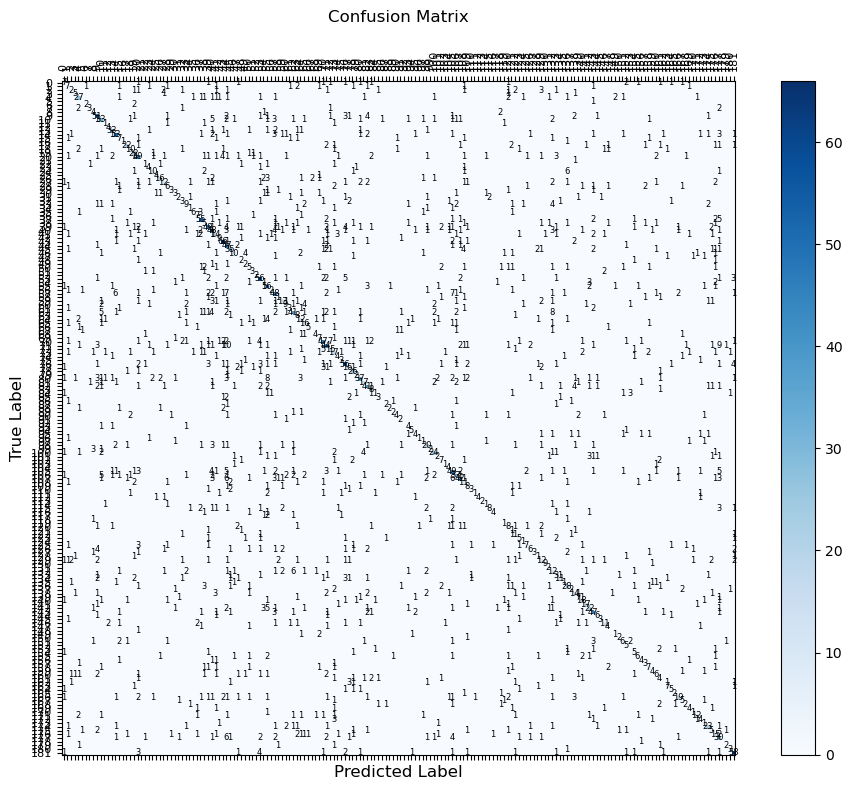

In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(all_labels, all_preds)

num_classes = conf_matrix.shape[0]

class_names = list(range(num_classes))

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)

# Add colorbar
fig.colorbar(cax)

# Set axis labels
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)

# Tick marks and class names
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(class_names, rotation=90, fontsize=8)
ax.set_yticklabels(class_names, fontsize=8)

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        value = conf_matrix[i, j]
        if value > 0:
            ax.text(j, i, str(value), va='center', ha='center', fontsize=6, color='black')

plt.title("Confusion Matrix", pad=20)
plt.tight_layout()
plt.show()

# garbage code below

# check spectrogramm

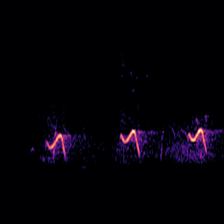

In [6]:

custom_p7_spectrograms_for_audio(f"{audio_input_folder}/asikoe2/", "XC138196.ogg",image_output_folder='dummy', preview=True)

retrieve support

In [ ]:
import pandas as pd
report=pd.read_csv('/home/christophe/birdclef/mlflow_artifacts/classification_report_2025-07-09_21-40-00.csv')
peport=report.iloc[:-3]

support=peport['support']


# POST TRAIN EFFECTS

In [ ]:
layers_folder_save='/home/christophe/birdclef/Model_check/'

fft_file_save=layers_folder_save+'fft_basis_post_train.joblib'
fft=joblib.load(filename=fft_file_save)




if mel_trainable:
    
    mel_basis_post_train=model_b.get_tachrotron_mel_basis()
    mel_file_save=filename=layers_folder_save+'mel_basis_post_train.joblib'
    joblib.dump(filename=mel_file_save,value=mel_basis_post_train)
    mlflow.log_artifact(mel_file_save)


# GARBAGE CODE BELOW

In [ ]:
meta_data = pd.read_csv(dataset_root_folder+"eBird_Taxonomy_v2021.csv")
birds_of_interest = [
    "Eurasian Coot", #
    "Blyth's Reed Warbler", #
    "Gray Heron", #
    "Greenish Warbler", #
    "Black-crowned Night-Heron", 
    "Rose-ringed Parakeet", #
    "Greater Racket-tailed Drongo", #
    "White-breasted Waterhen", #
    "Gray-headed Canary-Flycatcher", #
    "Great Egret", #
    "Little Egret", #
    "Red-whiskered Bulbul"#
]

print(len(birds_of_interest))
metadata_of_interest = meta_data[meta_data['PRIMARY_COM_NAME'].isin(birds_of_interest)]
print(metadata_of_interest.shape)
metadata_of_interest
def bird_species_from_folder(path):
    if path.endswith('/'):
        path = path[:-1]

    last_folder = os.path.basename(path)
    primary_com_name = metadata_of_interest.loc[metadata_of_interest['SPECIES_CODE'] == last_folder, 'PRIMARY_COM_NAME']
    primary_com_name_str = primary_com_name.iloc[0] if not primary_com_name.empty else ''    
    return f"{primary_com_name_str} ({last_folder})"

species_codes_of_interest = metadata_of_interest['SPECIES_CODE'].tolist()
species_codes_of_interest
# from PIL import Image as pil
# from pkg_resources import parse_version

# if parse_version(pil.__version__)>=parse_version('10.0.0'):
#     Image.ANTIALIAS=Image.LANCZOS

# List everything in the audio input folder
entries = os.listdir(audio_input_folder)

# Filter to get only directories
# subdirectories = [entry for entry in entries if os.path.isdir(os.path.join(audio_input_folder, entry))]
subdirectories = [entry for entry in entries if os.path.isdir(os.path.join(audio_input_folder, entry)) and entry in species_codes_of_interest]

# Sort the directories
subdirectories.sort()

#to start processing at a certain folder offset
subdirectories = subdirectories[start_at_folder_offset:]

folder_count = len(subdirectories)
folders_processed = 0

# Iterate through each sorted directory
total_images = 0
print('27 june first test images will be generated only for 1 folder')

for subdir in subdirectories:
    print('for now no image created')
    break
    subdir_path = os.path.join(audio_input_folder, subdir)
    folders_processed += 1
    print("\n", bird_species_from_folder(subdir_path), folders_processed, "/", folder_count)

    # List files in the current directory (in any order)
    filenames = os.listdir(subdir_path)
    
    # Process up to max_audio_input_per_species files
    images_this_species = 0
    for filename in filenames[:max_audio_input_per_species]:
        images_generated = spectrograms_for_audio(subdir_path, filename,preview=False)
        if images_generated > 0:
            images_this_species += images_generated
            print(".", end = "")
        else:
            print("X", end = "")
    print (f"({images_this_species} images generated)")
    total_images += images_this_species
    if folders_processed>0:
        break
print ("\n", total_images, "total images generated")
                